### **Смена сезонов на фото**

**Цель работы:** реализовать смену сезонов на фото, смену зимних и летних пейзажей.

**Задачи:**
*   Освоить фреймворк PyTorch
*   Провести обзор статей и работ по данной теме
*   Реализовать архитектуру CycleGAN
*   Провести обучение CycleGAN на датасете зимних и летних пейзажей



### Импортируем библиотеки

In [1]:
import os
import pdb
import pickle
import argparse
import numpy as np
import scipy
import scipy.misc
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

### Подключаем Google Disk

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Дополнительные функции

In [4]:
def scale(x, feature_range=(-1, 1)):
    """Необходимо преобразовать данные в соответстующий диапазон 
    в завимости от фукнции активации на выходе генератора"""
    min, max = feature_range
    x = x * (max - min) + min
    return x

[Detailed explanation of convolution and deconvolution in Pytorch (conv2d and convTranspose2d](https://www.programmersought.com/article/66075375215/)

In [74]:
def conv2D(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Сверточный слой с батч-нормализацией"""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [75]:
def ConvTrans2D(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Слой деконволюция (обратная операция свертки) с батч-нормализацией """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                     stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

[Saving and loading models in PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [76]:
def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='/content/drive/MyDrive/GAN/checkpoints_cyclegan'):
    """Сохраняем модель"""
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
    G_XtoY_path = os.path.join(checkpoint_dir, f'G_XtoY_{iteration}.pth')
    G_YtoX_path = os.path.join(checkpoint_dir, f'G_YtoX_{iteration}.pth')
    D_X_path = os.path.join(checkpoint_dir, f'D_X_{iteration}.pth')
    D_Y_path = os.path.join(checkpoint_dir, f'D_Y_{iteration}.pth')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)

In [77]:
def merge_images(sources, targets, batch_size=16):
    """Создаем пары изображений: реальное и сгенирированное фото"""
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged

In [78]:
def to_data(x):
    """Переводим тензор в array"""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8)
    return x

In [79]:
def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='/content/drive/MyDrive/GAN/samples_cyclegan'):
    """Сохраняем промежуточные результаты в виде пар изображений"""
    if not os.path.exists(sample_dir):
      os.makedirs(sample_dir)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [80]:
def myimage_loader(image_dir='/content/drive/MyDrive/GAN/mypages', image_size=128, batch_size=16):
      if not os.path.exists(image_dir):
        os.makedirs(image_dir)
      transform = transforms.Compose([transforms.Resize([image_size, image_size]),
                                    transforms.ToTensor()])
      image_path = os.path.join('./', image_dir)
      myimage_dataset = datasets.ImageFolder(image_path, transform)
      myimage_loader = DataLoader(dataset=myimage_dataset, batch_size=batch_size, shuffle=True)
      return myimage_loader
my_loader = myimage_loader()

### Скачиваем данные
В качестве данных рассматривается датасет состоящий из фотографий летних и зимних пейзажей ["Национального парка Йосемити".](https://en.wikipedia.org/wiki/Yosemite_National_Park)

Датасет Summer2Winter Yosemite состоит из 1540 летних фото и 1200 зимних, разделенных на тренировочное и тестовое множества

In [ ]:
!wget 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip'
!unzip '/content/summer2winter-yosemite.zip'

###Сделаем загрузчик изображений и посмотрим на изображения

[PyTorch DataLoader](https://pytorch.org/docs/stable/data.html) аналог ImageDataGenerator в Keras

[PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html)

[Torchvision Datasets](https://pytorch.org/vision/stable/datasets.html)

[Torchvision Utils](https://pytorch.org/vision/stable/utils.html)

In [81]:
def dataset_loader(data_path, season, img_size=(128, 128), batch_size=16):
  """
  Функция разбивает датасет, изменяет размер изображения и переводит изображение в тензор.
  """
  transform = transforms.Compose([transforms.Resize(img_size), 
                                  transforms.ToTensor()
                                  ])
  train_path, test_path = os.path.join(data_path, season), os.path.join(data_path, f'test_{season}')
  print(train_path, test_path)

  train_data, test_data = datasets.ImageFolder(train_path, transform), datasets.ImageFolder(test_path, transform)
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

  return train_loader, test_loader

In [82]:
X_loader, X_test_loader = dataset_loader(data_path='./summer2winter_yosemite', season='summer')
Y_loader, Y_test_loader = dataset_loader(data_path='./summer2winter_yosemite', season='winter')


./summer2winter_yosemite/summer ./summer2winter_yosemite/test_summer
./summer2winter_yosemite/winter ./summer2winter_yosemite/test_winter


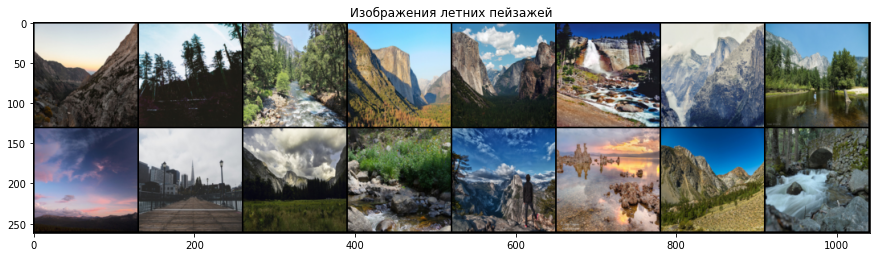

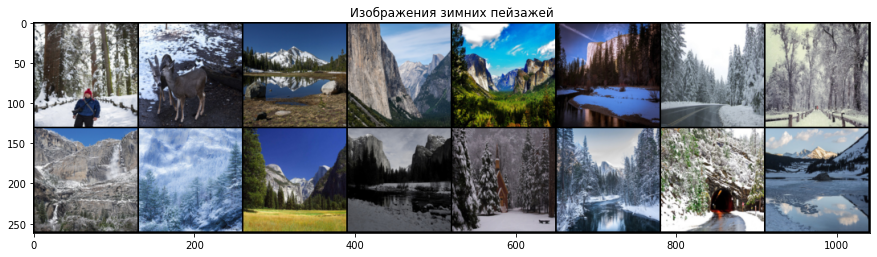

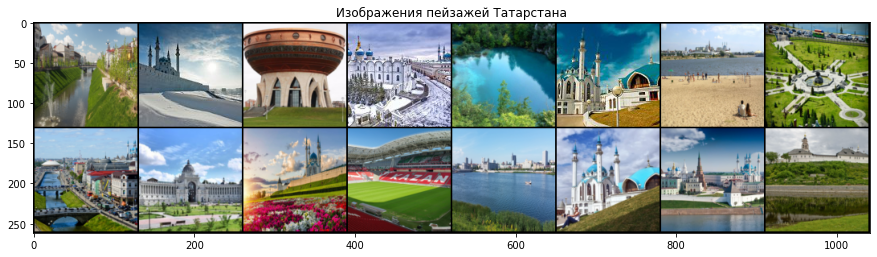

In [83]:
iterator = iter(X_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения летних пейзажей')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

iterator = iter(Y_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения зимних пейзажей')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

iterator = iter(my_loader)
img, _ = iterator.next()
fig = plt.figure(figsize = (15, 10))
tens = torchvision.utils.make_grid(img)
img_np = tens.numpy()
plt.title('Изображения пейзажей Татарстана')
plt.imshow(np.transpose(img_np, (1, 2, 0)));

## Определим нашу модель

![](https://raw.githubusercontent.com/yunjey/mnist-svhn-transfer/master/gif/cyclegan.png)

[PyTorch Layers](https://pytorch.org/docs/stable/nn.html)

### Residual Block

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [26]:
class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()
    self.layer_1 = conv2D(conv_dim, conv_dim, 3, 1, 1, batch_norm=True)
    self.layer_2 = conv2D(conv_dim, conv_dim, 3, 1, 1, batch_norm=True)

  def forward(self, x):
    out_1 = F.relu(self.layer_1(x))
    out_2 = x + self.layer_2(out_1)
    return out_2

### Generator

Архитектура Генератора
![](https://raw.githubusercontent.com/vjrahil/CycleGAN-in-Pytorch/cbe44b5097cfd876f299e31abfe98d8d578760cb/notebook_images/cyclegan_generator_ex.png)

In [27]:
class Generator(nn.Module):

    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(Generator, self).__init__()
        self.layer_1 = conv2D(3, conv_dim, 4)
        self.layer_2 = conv2D(conv_dim, conv_dim * 2, 4)
        self.layer_3 = conv2D(conv_dim * 2, conv_dim * 4, 4)
        layers = []
        for n in range(n_res_blocks):
            layers.append(ResidualBlock(conv_dim * 4))
        self.res_blocks = nn.Sequential(*layers)
        self.layer_4 = ConvTrans2D(conv_dim * 4, conv_dim * 2, 4)
        self.layer_5 = ConvTrans2D(conv_dim * 2 , conv_dim, 4)
        self.layer_6 = ConvTrans2D(conv_dim, 3, 4, batch_norm = False)


    def forward(self, x):
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
        out = F.relu(self.layer_3(out))
        out = self.res_blocks(out)
        out = F.relu(self.layer_4(out))
        out = F.relu(self.layer_5(out))
        out = F.tanh(self.layer_6(out))
        return out

### Discriminator

Архитектура Дискриминатора
![](https://raw.githubusercontent.com/vjrahil/CycleGAN-in-Pytorch/cbe44b5097cfd876f299e31abfe98d8d578760cb/notebook_images/discriminator_layers.png)


In [28]:
class Discriminator(nn.Module):
  
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.layer_1 = conv2D(3, conv_dim, 4, batch_norm = False)
        self.layer_2 = conv2D(conv_dim, conv_dim * 2, 4)
        self.layer_3 = conv2D(conv_dim * 2, conv_dim * 4, 4)
        self.layer_4 = conv2D(conv_dim * 4, conv_dim * 8, 4)
        self.layer_5 = conv2D(conv_dim * 8, 1, 4, 1, batch_norm = False)
        

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.relu(self.layer_4(x))
        x = self.layer_5(x)
        return x


###Инициализируем веса

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Собираем модель

In [167]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    
    G_XtoY = Generator(g_conv_dim, n_res_blocks)
    G_YtoX = Generator(g_conv_dim, n_res_blocks)

    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)
    
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_XtoY.apply(weights_init)
        G_YtoX.to(device)
        G_YtoX.apply(weights_init)
        D_X.to(device)
        D_X.apply(weights_init)
        D_Y.to(device)
        D_Y.apply(weights_init)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [168]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [169]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
Generator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (layer_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

### Определяем функции потерь

![](https://github.com/vjrahil/CycleGAN-in-Pytorch/raw/cbe44b5097cfd876f299e31abfe98d8d578760cb/notebook_images/CycleGAN_loss.png)

In [134]:
def real_mse_loss(D_out):
    return torch.mean((D_out - 1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return loss*lambda_weight

### Определяем функции оптимизации и гиперпараметры

In [170]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

lambda_rule = lambda epoch: 1.0 - max(0, epoch - 2500) / (5000 + 1)
scheduler_g_optimizer = lr_scheduler.LambdaLR(g_optimizer, lr_lambda=lambda_rule)
schedulerd_x_optimizer = lr_scheduler.LambdaLR(d_x_optimizer, lr_lambda=lambda_rule)
schedulerd_y_optimizer = lr_scheduler.LambdaLR(d_y_optimizer, lr_lambda=lambda_rule)

In [171]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    losses = []
    test_iter_X, test_iter_Y = iter(test_dataloader_X), iter(test_dataloader_Y)
    fixed_X, fixed_Y = test_iter_X.next()[0], test_iter_Y.next()[0]
    fixed_X, fixed_Y = scale(fixed_X), scale(fixed_Y)


    """myimages"""
    my_iter_X = iter(my_loader)
    my_fixed_X = my_iter_X.next()[0]
    my_fixed_X = scale(my_fixed_X)

    iter_X, iter_Y = iter(dataloader_X), iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    lrs_g_optimizer = []
    lrs_x_optimizer = []
    lrs_y_optimizer = []
    for epoch in range(1, n_epochs+1):

        if epoch % batches_per_epoch == 0:
            iter_X, iter_Y = iter(dataloader_X), iter(dataloader_Y)
        images_X, _ = iter_X.next()
        images_Y, _ = iter_Y.next()
        images_X, images_Y = scale(images_X), scale(images_Y)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X, images_Y = images_X.to(device), images_Y.to(device)
        
        d_x_optimizer.zero_grad()
        real_D_loss = real_mse_loss(D_X(images_X))
        fake_D_loss = fake_mse_loss(D_X(G_YtoX(images_Y)))
        d_x_loss = real_D_loss + fake_D_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        d_y_optimizer.zero_grad()
        real_D_y_loss = real_mse_loss(D_Y(images_Y))
        fake_D_y_loss = fake_mse_loss(D_Y(G_XtoY(images_X)))
        d_y_loss = real_D_y_loss + fake_D_y_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        g_optimizer.zero_grad()
        out_1 = G_YtoX(images_Y)
        loss_1 = real_mse_loss(D_X(out_1))
        out_2 = G_XtoY(out_1)
        loss_2 = cycle_consistency_loss(real_im = images_Y, reconstructed_im = out_2, lambda_weight=10)
        out_3 = G_XtoY(images_X)
        loss_3 = real_mse_loss(D_Y(out_3))
        out_4 = G_YtoX(out_3)
        loss_4 =  cycle_consistency_loss(real_im = images_X, reconstructed_im = out_4, lambda_weight=10)

        g_total_loss = loss_1 + loss_2 + loss_3 + loss_4
        g_total_loss.backward()
        g_optimizer.step()
        
        lrs_g_optimizer.append(g_optimizer.param_groups[0]["lr"])
        lrs_x_optimizer.append(d_x_optimizer.param_groups[0]["lr"])
        lrs_y_optimizer.append(d_y_optimizer.param_groups[0]["lr"])
        scheduler_g_optimizer.step()
        schedulerd_x_optimizer.step()
        schedulerd_y_optimizer.step()

        if epoch % print_every == 0:
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        if epoch % sample_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            save_samples(epoch, my_fixed_X, my_fixed_X, G_YtoX, G_XtoY, sample_dir='/content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan')
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=1000
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses, lrs_g_optimizer, lrs_x_optimizer, lrs_y_optimizer

In [172]:
from datetime import datetime
start_time = datetime.now()
n_epochs = 5000

losses, lrs_g_optimizer, lrs_x_optimizer, lrs_y_optimizer = training_loop(X_loader, Y_loader, X_test_loader, Y_test_loader, n_epochs=n_epochs)
print('Time:', datetime.now() - start_time)

Epoch [   10/ 5000] | d_X_loss: 1.8467 | d_Y_loss: 2.3393 | g_total_loss: 12.8910
Epoch [   20/ 5000] | d_X_loss: 1.3641 | d_Y_loss: 1.9961 | g_total_loss: 13.0352
Epoch [   30/ 5000] | d_X_loss: 1.7234 | d_Y_loss: 1.0541 | g_total_loss: 12.8995
Epoch [   40/ 5000] | d_X_loss: 0.7215 | d_Y_loss: 0.8421 | g_total_loss: 9.3583
Epoch [   50/ 5000] | d_X_loss: 0.6793 | d_Y_loss: 0.8660 | g_total_loss: 9.0464
Epoch [   60/ 5000] | d_X_loss: 0.7386 | d_Y_loss: 1.4435 | g_total_loss: 8.1826
Epoch [   70/ 5000] | d_X_loss: 0.4700 | d_Y_loss: 0.5935 | g_total_loss: 6.4068
Epoch [   80/ 5000] | d_X_loss: 0.5704 | d_Y_loss: 0.6632 | g_total_loss: 5.5146
Epoch [   90/ 5000] | d_X_loss: 0.6639 | d_Y_loss: 0.5698 | g_total_loss: 5.6070


Epoch [  100/ 5000] | d_X_loss: 0.6912 | d_Y_loss: 0.6034 | g_total_loss: 5.2678


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000100-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000100-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000100-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.5873 | d_Y_loss: 0.6771 | g_total_loss: 4.8744
Epoch [  120/ 5000] | d_X_loss: 0.5087 | d_Y_loss: 0.5580 | g_total_loss: 4.5740
Epoch [  130/ 5000] | d_X_loss: 0.5617 | d_Y_loss: 0.6089 | g_total_loss: 4.9759
Epoch [  140/ 5000] | d_X_loss: 0.6161 | d_Y_loss: 0.5913 | g_total_loss: 4.5133
Epoch [  150/ 5000] | d_X_loss: 0.6245 | d_Y_loss: 0.6298 | g_total_loss: 4.4273
Epoch [  160/ 5000] | d_X_loss: 0.5754 | d_Y_loss: 0.5598 | g_total_loss: 4.0451
Epoch [  170/ 5000] | d_X_loss: 0.5625 | d_Y_loss: 0.6116 | g_total_loss: 4.1295
Epoch [  180/ 5000] | d_X_loss: 0.5932 | d_Y_loss: 0.6495 | g_total_loss: 4.2460
Epoch [  190/ 5000] | d_X_loss: 0.5526 | d_Y_loss: 0.5289 | g_total_loss: 4.2425


Epoch [  200/ 5000] | d_X_loss: 0.4975 | d_Y_loss: 0.5032 | g_total_loss: 3.6738


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000200-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000200-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000200-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.5275 | d_Y_loss: 0.5040 | g_total_loss: 3.9419
Epoch [  220/ 5000] | d_X_loss: 0.5702 | d_Y_loss: 0.5344 | g_total_loss: 3.9423
Epoch [  230/ 5000] | d_X_loss: 0.5268 | d_Y_loss: 0.5849 | g_total_loss: 4.1167
Epoch [  240/ 5000] | d_X_loss: 0.6049 | d_Y_loss: 0.5449 | g_total_loss: 4.1767
Epoch [  250/ 5000] | d_X_loss: 0.5950 | d_Y_loss: 0.5874 | g_total_loss: 4.0293
Epoch [  260/ 5000] | d_X_loss: 0.5791 | d_Y_loss: 0.5751 | g_total_loss: 3.6765
Epoch [  270/ 5000] | d_X_loss: 0.5275 | d_Y_loss: 0.5727 | g_total_loss: 3.9012
Epoch [  280/ 5000] | d_X_loss: 0.5912 | d_Y_loss: 0.5077 | g_total_loss: 3.9212
Epoch [  290/ 5000] | d_X_loss: 0.4544 | d_Y_loss: 0.5126 | g_total_loss: 3.9282


Epoch [  300/ 5000] | d_X_loss: 0.4870 | d_Y_loss: 0.4885 | g_total_loss: 4.2884


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000300-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000300-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000300-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.4804 | d_Y_loss: 0.5139 | g_total_loss: 4.2757
Epoch [  320/ 5000] | d_X_loss: 0.6330 | d_Y_loss: 0.4993 | g_total_loss: 3.6633
Epoch [  330/ 5000] | d_X_loss: 0.5359 | d_Y_loss: 0.6461 | g_total_loss: 3.7330
Epoch [  340/ 5000] | d_X_loss: 0.5379 | d_Y_loss: 0.5344 | g_total_loss: 3.8960
Epoch [  350/ 5000] | d_X_loss: 0.5305 | d_Y_loss: 0.4941 | g_total_loss: 3.6115
Epoch [  360/ 5000] | d_X_loss: 0.4983 | d_Y_loss: 0.4752 | g_total_loss: 3.9790
Epoch [  370/ 5000] | d_X_loss: 0.5665 | d_Y_loss: 0.5703 | g_total_loss: 4.0047
Epoch [  380/ 5000] | d_X_loss: 0.4981 | d_Y_loss: 0.5380 | g_total_loss: 4.0327
Epoch [  390/ 5000] | d_X_loss: 0.5012 | d_Y_loss: 0.4608 | g_total_loss: 3.3195


Epoch [  400/ 5000] | d_X_loss: 0.6310 | d_Y_loss: 0.5804 | g_total_loss: 3.9913


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000400-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000400-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000400-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.5490 | d_Y_loss: 0.5107 | g_total_loss: 3.5280
Epoch [  420/ 5000] | d_X_loss: 0.4860 | d_Y_loss: 0.5839 | g_total_loss: 3.6072
Epoch [  430/ 5000] | d_X_loss: 0.5643 | d_Y_loss: 0.6018 | g_total_loss: 3.5754
Epoch [  440/ 5000] | d_X_loss: 0.5238 | d_Y_loss: 0.6117 | g_total_loss: 3.8477
Epoch [  450/ 5000] | d_X_loss: 0.5857 | d_Y_loss: 0.4970 | g_total_loss: 3.2321
Epoch [  460/ 5000] | d_X_loss: 0.5198 | d_Y_loss: 0.5540 | g_total_loss: 3.3172
Epoch [  470/ 5000] | d_X_loss: 0.4774 | d_Y_loss: 0.4420 | g_total_loss: 3.4305
Epoch [  480/ 5000] | d_X_loss: 0.5156 | d_Y_loss: 0.5275 | g_total_loss: 3.5903
Epoch [  490/ 5000] | d_X_loss: 0.4137 | d_Y_loss: 0.5922 | g_total_loss: 4.3452


Epoch [  500/ 5000] | d_X_loss: 0.5186 | d_Y_loss: 0.5649 | g_total_loss: 3.3483


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000500-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000500-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000500-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.5659 | d_Y_loss: 0.5393 | g_total_loss: 3.6154
Epoch [  520/ 5000] | d_X_loss: 0.5031 | d_Y_loss: 0.4602 | g_total_loss: 3.8796
Epoch [  530/ 5000] | d_X_loss: 0.5298 | d_Y_loss: 0.5572 | g_total_loss: 3.2725
Epoch [  540/ 5000] | d_X_loss: 0.5088 | d_Y_loss: 0.4710 | g_total_loss: 3.7382
Epoch [  550/ 5000] | d_X_loss: 0.5850 | d_Y_loss: 0.5986 | g_total_loss: 3.4258
Epoch [  560/ 5000] | d_X_loss: 0.5482 | d_Y_loss: 0.5184 | g_total_loss: 3.4094
Epoch [  570/ 5000] | d_X_loss: 0.5380 | d_Y_loss: 0.7717 | g_total_loss: 3.4272
Epoch [  580/ 5000] | d_X_loss: 0.4992 | d_Y_loss: 0.4746 | g_total_loss: 3.5273
Epoch [  590/ 5000] | d_X_loss: 0.5109 | d_Y_loss: 0.5090 | g_total_loss: 3.0700


Epoch [  600/ 5000] | d_X_loss: 0.4906 | d_Y_loss: 0.5561 | g_total_loss: 3.2470


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000600-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000600-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000600-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.5598 | d_Y_loss: 0.6598 | g_total_loss: 4.2594
Epoch [  620/ 5000] | d_X_loss: 0.4420 | d_Y_loss: 0.5451 | g_total_loss: 3.9887
Epoch [  630/ 5000] | d_X_loss: 0.4970 | d_Y_loss: 0.4749 | g_total_loss: 3.5166
Epoch [  640/ 5000] | d_X_loss: 0.5236 | d_Y_loss: 0.5035 | g_total_loss: 3.6046
Epoch [  650/ 5000] | d_X_loss: 0.5679 | d_Y_loss: 0.5008 | g_total_loss: 3.8340
Epoch [  660/ 5000] | d_X_loss: 0.5185 | d_Y_loss: 0.5231 | g_total_loss: 3.3083
Epoch [  670/ 5000] | d_X_loss: 0.4555 | d_Y_loss: 0.4685 | g_total_loss: 4.6949
Epoch [  680/ 5000] | d_X_loss: 0.5034 | d_Y_loss: 0.8376 | g_total_loss: 2.8956
Epoch [  690/ 5000] | d_X_loss: 0.4992 | d_Y_loss: 0.5303 | g_total_loss: 3.7206


Epoch [  700/ 5000] | d_X_loss: 0.5690 | d_Y_loss: 0.5676 | g_total_loss: 3.6208


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000700-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000700-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000700-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.4975 | d_Y_loss: 0.5039 | g_total_loss: 3.3787
Epoch [  720/ 5000] | d_X_loss: 0.4540 | d_Y_loss: 0.4695 | g_total_loss: 3.8076
Epoch [  730/ 5000] | d_X_loss: 0.3770 | d_Y_loss: 0.4627 | g_total_loss: 3.8000
Epoch [  740/ 5000] | d_X_loss: 0.6065 | d_Y_loss: 0.5734 | g_total_loss: 3.5079
Epoch [  750/ 5000] | d_X_loss: 0.5064 | d_Y_loss: 0.5665 | g_total_loss: 3.4116
Epoch [  760/ 5000] | d_X_loss: 0.5108 | d_Y_loss: 0.4972 | g_total_loss: 3.1982
Epoch [  770/ 5000] | d_X_loss: 0.5167 | d_Y_loss: 0.4027 | g_total_loss: 3.3855
Epoch [  780/ 5000] | d_X_loss: 0.5305 | d_Y_loss: 0.5010 | g_total_loss: 3.7592
Epoch [  790/ 5000] | d_X_loss: 0.4728 | d_Y_loss: 0.4845 | g_total_loss: 3.1895


Epoch [  800/ 5000] | d_X_loss: 0.5695 | d_Y_loss: 0.4489 | g_total_loss: 3.6769


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000800-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000800-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000800-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.4807 | d_Y_loss: 0.4670 | g_total_loss: 3.9808
Epoch [  820/ 5000] | d_X_loss: 0.4689 | d_Y_loss: 0.4741 | g_total_loss: 3.6757
Epoch [  830/ 5000] | d_X_loss: 0.5092 | d_Y_loss: 0.4780 | g_total_loss: 3.1436
Epoch [  840/ 5000] | d_X_loss: 0.4225 | d_Y_loss: 0.4252 | g_total_loss: 3.8913
Epoch [  850/ 5000] | d_X_loss: 0.3855 | d_Y_loss: 0.4799 | g_total_loss: 3.8997
Epoch [  860/ 5000] | d_X_loss: 0.5231 | d_Y_loss: 0.5734 | g_total_loss: 3.3544
Epoch [  870/ 5000] | d_X_loss: 0.6162 | d_Y_loss: 0.4848 | g_total_loss: 3.0971
Epoch [  880/ 5000] | d_X_loss: 0.5274 | d_Y_loss: 0.4619 | g_total_loss: 4.3382
Epoch [  890/ 5000] | d_X_loss: 0.4147 | d_Y_loss: 0.3937 | g_total_loss: 3.3187


Epoch [  900/ 5000] | d_X_loss: 0.5032 | d_Y_loss: 0.5040 | g_total_loss: 2.9948


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000900-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-000900-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000900-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.5271 | d_Y_loss: 0.4784 | g_total_loss: 3.1154
Epoch [  920/ 5000] | d_X_loss: 0.4012 | d_Y_loss: 0.3850 | g_total_loss: 3.7188
Epoch [  930/ 5000] | d_X_loss: 0.4586 | d_Y_loss: 0.4827 | g_total_loss: 3.1592
Epoch [  940/ 5000] | d_X_loss: 0.4990 | d_Y_loss: 0.3537 | g_total_loss: 3.3793
Epoch [  950/ 5000] | d_X_loss: 0.5381 | d_Y_loss: 0.6425 | g_total_loss: 3.7314
Epoch [  960/ 5000] | d_X_loss: 0.4809 | d_Y_loss: 0.5362 | g_total_loss: 3.4847
Epoch [  970/ 5000] | d_X_loss: 0.5295 | d_Y_loss: 0.5259 | g_total_loss: 3.0686
Epoch [  980/ 5000] | d_X_loss: 0.4815 | d_Y_loss: 0.4614 | g_total_loss: 3.9360
Epoch [  990/ 5000] | d_X_loss: 0.4525 | d_Y_loss: 0.4555 | g_total_loss: 3.5119


Epoch [ 1000/ 5000] | d_X_loss: 0.5232 | d_Y_loss: 0.5559 | g_total_loss: 3.1993


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001000-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001000-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.4973 | d_Y_loss: 0.5153 | g_total_loss: 3.2077
Epoch [ 1020/ 5000] | d_X_loss: 0.4720 | d_Y_loss: 0.4989 | g_total_loss: 3.4651
Epoch [ 1030/ 5000] | d_X_loss: 0.4161 | d_Y_loss: 0.3793 | g_total_loss: 3.3183
Epoch [ 1040/ 5000] | d_X_loss: 0.4881 | d_Y_loss: 0.4632 | g_total_loss: 3.6658
Epoch [ 1050/ 5000] | d_X_loss: 0.4904 | d_Y_loss: 0.5181 | g_total_loss: 3.2498
Epoch [ 1060/ 5000] | d_X_loss: 0.4243 | d_Y_loss: 0.4467 | g_total_loss: 3.2798
Epoch [ 1070/ 5000] | d_X_loss: 0.5101 | d_Y_loss: 0.5287 | g_total_loss: 3.0318
Epoch [ 1080/ 5000] | d_X_loss: 0.4864 | d_Y_loss: 0.5378 | g_total_loss: 3.2135
Epoch [ 1090/ 5000] | d_X_loss: 0.4676 | d_Y_loss: 0.4418 | g_total_loss: 3.2100


Epoch [ 1100/ 5000] | d_X_loss: 0.4614 | d_Y_loss: 0.4981 | g_total_loss: 3.3109


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001100-X-Y.png
Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001100-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001100-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.5100 | d_Y_loss: 0.4544 | g_total_loss: 3.1592
Epoch [ 1120/ 5000] | d_X_loss: 1.3872 | d_Y_loss: 0.3477 | g_total_loss: 5.4705
Epoch [ 1130/ 5000] | d_X_loss: 0.4767 | d_Y_loss: 0.4531 | g_total_loss: 3.7767
Epoch [ 1140/ 5000] | d_X_loss: 0.4967 | d_Y_loss: 0.3981 | g_total_loss: 3.7311
Epoch [ 1150/ 5000] | d_X_loss: 0.5230 | d_Y_loss: 0.5298 | g_total_loss: 3.2464
Epoch [ 1160/ 5000] | d_X_loss: 0.5157 | d_Y_loss: 0.5510 | g_total_loss: 3.3926
Epoch [ 1170/ 5000] | d_X_loss: 0.5145 | d_Y_loss: 0.5205 | g_total_loss: 3.1037
Epoch [ 1180/ 5000] | d_X_loss: 0.4647 | d_Y_loss: 0.4820 | g_total_loss: 3.0905
Epoch [ 1190/ 5000] | d_X_loss: 0.4814 | d_Y_loss: 0.4651 | g_total_loss: 3.4055


Epoch [ 1200/ 5000] | d_X_loss: 0.5089 | d_Y_loss: 0.5451 | g_total_loss: 2.9325


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001200-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001200-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001200-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.4842 | d_Y_loss: 0.5124 | g_total_loss: 3.0541
Epoch [ 1220/ 5000] | d_X_loss: 0.4909 | d_Y_loss: 0.4872 | g_total_loss: 3.4820
Epoch [ 1230/ 5000] | d_X_loss: 0.4752 | d_Y_loss: 0.5155 | g_total_loss: 3.3630
Epoch [ 1240/ 5000] | d_X_loss: 0.4500 | d_Y_loss: 0.4770 | g_total_loss: 3.1295
Epoch [ 1250/ 5000] | d_X_loss: 0.4595 | d_Y_loss: 0.4344 | g_total_loss: 3.0514
Epoch [ 1260/ 5000] | d_X_loss: 0.4734 | d_Y_loss: 0.4600 | g_total_loss: 2.9895
Epoch [ 1270/ 5000] | d_X_loss: 0.4583 | d_Y_loss: 0.6150 | g_total_loss: 3.0796
Epoch [ 1280/ 5000] | d_X_loss: 0.4224 | d_Y_loss: 0.4903 | g_total_loss: 3.7044
Epoch [ 1290/ 5000] | d_X_loss: 0.4628 | d_Y_loss: 0.4773 | g_total_loss: 3.3015


Epoch [ 1300/ 5000] | d_X_loss: 0.4434 | d_Y_loss: 0.5118 | g_total_loss: 2.9317


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001300-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001300-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001300-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.4686 | d_Y_loss: 0.4921 | g_total_loss: 3.0562
Epoch [ 1320/ 5000] | d_X_loss: 0.5659 | d_Y_loss: 0.4900 | g_total_loss: 3.1924
Epoch [ 1330/ 5000] | d_X_loss: 0.4291 | d_Y_loss: 0.4747 | g_total_loss: 3.6621
Epoch [ 1340/ 5000] | d_X_loss: 0.4402 | d_Y_loss: 0.4861 | g_total_loss: 3.0478
Epoch [ 1350/ 5000] | d_X_loss: 0.5356 | d_Y_loss: 0.4935 | g_total_loss: 3.5376
Epoch [ 1360/ 5000] | d_X_loss: 0.4932 | d_Y_loss: 0.4526 | g_total_loss: 3.3734
Epoch [ 1370/ 5000] | d_X_loss: 0.5578 | d_Y_loss: 0.5263 | g_total_loss: 3.2297
Epoch [ 1380/ 5000] | d_X_loss: 0.4493 | d_Y_loss: 0.5115 | g_total_loss: 3.6574
Epoch [ 1390/ 5000] | d_X_loss: 0.4814 | d_Y_loss: 0.5477 | g_total_loss: 3.4574


Epoch [ 1400/ 5000] | d_X_loss: 0.4713 | d_Y_loss: 0.5029 | g_total_loss: 3.2259


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001400-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001400-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001400-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.3804 | d_Y_loss: 0.3230 | g_total_loss: 3.5918
Epoch [ 1420/ 5000] | d_X_loss: 0.3883 | d_Y_loss: 0.4316 | g_total_loss: 2.9417
Epoch [ 1430/ 5000] | d_X_loss: 0.4843 | d_Y_loss: 0.3267 | g_total_loss: 3.1138
Epoch [ 1440/ 5000] | d_X_loss: 0.4164 | d_Y_loss: 0.4730 | g_total_loss: 3.3023
Epoch [ 1450/ 5000] | d_X_loss: 0.5032 | d_Y_loss: 0.4713 | g_total_loss: 3.9494
Epoch [ 1460/ 5000] | d_X_loss: 0.4131 | d_Y_loss: 0.4496 | g_total_loss: 3.6123
Epoch [ 1470/ 5000] | d_X_loss: 0.4670 | d_Y_loss: 0.5113 | g_total_loss: 3.1382
Epoch [ 1480/ 5000] | d_X_loss: 0.5152 | d_Y_loss: 0.4445 | g_total_loss: 3.2545
Epoch [ 1490/ 5000] | d_X_loss: 0.4614 | d_Y_loss: 0.4767 | g_total_loss: 3.5720


Epoch [ 1500/ 5000] | d_X_loss: 0.4965 | d_Y_loss: 0.5157 | g_total_loss: 3.6267


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001500-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001500-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001500-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.4182 | d_Y_loss: 0.4870 | g_total_loss: 3.0778
Epoch [ 1520/ 5000] | d_X_loss: 0.4040 | d_Y_loss: 0.4127 | g_total_loss: 3.2446
Epoch [ 1530/ 5000] | d_X_loss: 0.4265 | d_Y_loss: 0.2922 | g_total_loss: 3.3708
Epoch [ 1540/ 5000] | d_X_loss: 0.5327 | d_Y_loss: 0.5012 | g_total_loss: 2.9697
Epoch [ 1550/ 5000] | d_X_loss: 0.4989 | d_Y_loss: 0.5335 | g_total_loss: 2.9879
Epoch [ 1560/ 5000] | d_X_loss: 0.4589 | d_Y_loss: 0.5707 | g_total_loss: 3.3268
Epoch [ 1570/ 5000] | d_X_loss: 0.5577 | d_Y_loss: 0.5185 | g_total_loss: 4.6276
Epoch [ 1580/ 5000] | d_X_loss: 0.3609 | d_Y_loss: 0.4839 | g_total_loss: 3.8388
Epoch [ 1590/ 5000] | d_X_loss: 0.5039 | d_Y_loss: 0.4702 | g_total_loss: 4.1605


Epoch [ 1600/ 5000] | d_X_loss: 0.4408 | d_Y_loss: 0.4539 | g_total_loss: 3.5784


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001600-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001600-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001600-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.4223 | d_Y_loss: 0.5630 | g_total_loss: 3.2599
Epoch [ 1620/ 5000] | d_X_loss: 0.4948 | d_Y_loss: 0.5439 | g_total_loss: 3.0956
Epoch [ 1630/ 5000] | d_X_loss: 0.4462 | d_Y_loss: 0.4514 | g_total_loss: 3.1648
Epoch [ 1640/ 5000] | d_X_loss: 0.4910 | d_Y_loss: 0.5935 | g_total_loss: 3.2140
Epoch [ 1650/ 5000] | d_X_loss: 0.3918 | d_Y_loss: 0.5126 | g_total_loss: 3.0996
Epoch [ 1660/ 5000] | d_X_loss: 0.4551 | d_Y_loss: 0.4231 | g_total_loss: 3.4406
Epoch [ 1670/ 5000] | d_X_loss: 0.4789 | d_Y_loss: 0.5400 | g_total_loss: 3.2527
Epoch [ 1680/ 5000] | d_X_loss: 0.3956 | d_Y_loss: 0.4444 | g_total_loss: 3.2028
Epoch [ 1690/ 5000] | d_X_loss: 0.4669 | d_Y_loss: 0.4655 | g_total_loss: 3.2290


Epoch [ 1700/ 5000] | d_X_loss: 0.4393 | d_Y_loss: 0.4707 | g_total_loss: 3.0474


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001700-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001700-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001700-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.4716 | d_Y_loss: 0.5098 | g_total_loss: 3.0767
Epoch [ 1720/ 5000] | d_X_loss: 0.4631 | d_Y_loss: 0.4868 | g_total_loss: 3.3212
Epoch [ 1730/ 5000] | d_X_loss: 0.6997 | d_Y_loss: 0.6113 | g_total_loss: 3.1223
Epoch [ 1740/ 5000] | d_X_loss: 0.4728 | d_Y_loss: 0.4595 | g_total_loss: 3.5042
Epoch [ 1750/ 5000] | d_X_loss: 0.3705 | d_Y_loss: 0.4830 | g_total_loss: 3.7357
Epoch [ 1760/ 5000] | d_X_loss: 0.4965 | d_Y_loss: 0.3653 | g_total_loss: 4.2170
Epoch [ 1770/ 5000] | d_X_loss: 0.5543 | d_Y_loss: 0.7319 | g_total_loss: 3.3284
Epoch [ 1780/ 5000] | d_X_loss: 0.3678 | d_Y_loss: 0.4126 | g_total_loss: 3.2766
Epoch [ 1790/ 5000] | d_X_loss: 0.4371 | d_Y_loss: 0.4724 | g_total_loss: 3.5017


Epoch [ 1800/ 5000] | d_X_loss: 0.4072 | d_Y_loss: 0.4868 | g_total_loss: 3.0688


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001800-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001800-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001800-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.4112 | d_Y_loss: 0.4859 | g_total_loss: 3.1190
Epoch [ 1820/ 5000] | d_X_loss: 0.4454 | d_Y_loss: 0.4456 | g_total_loss: 3.0434
Epoch [ 1830/ 5000] | d_X_loss: 0.5367 | d_Y_loss: 0.5005 | g_total_loss: 3.7652
Epoch [ 1840/ 5000] | d_X_loss: 0.4807 | d_Y_loss: 0.4860 | g_total_loss: 2.9511
Epoch [ 1850/ 5000] | d_X_loss: 0.6672 | d_Y_loss: 0.4865 | g_total_loss: 3.7335
Epoch [ 1860/ 5000] | d_X_loss: 0.4067 | d_Y_loss: 0.4984 | g_total_loss: 2.8613
Epoch [ 1870/ 5000] | d_X_loss: 0.3783 | d_Y_loss: 0.5258 | g_total_loss: 3.2794
Epoch [ 1880/ 5000] | d_X_loss: 0.4392 | d_Y_loss: 0.4624 | g_total_loss: 3.0445
Epoch [ 1890/ 5000] | d_X_loss: 0.4900 | d_Y_loss: 0.5877 | g_total_loss: 5.0704


Epoch [ 1900/ 5000] | d_X_loss: 0.5008 | d_Y_loss: 0.6582 | g_total_loss: 3.1376


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001900-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-001900-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001900-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.4367 | d_Y_loss: 0.5225 | g_total_loss: 3.2379
Epoch [ 1920/ 5000] | d_X_loss: 0.4326 | d_Y_loss: 0.5878 | g_total_loss: 3.0858
Epoch [ 1930/ 5000] | d_X_loss: 0.5032 | d_Y_loss: 0.4805 | g_total_loss: 2.7999
Epoch [ 1940/ 5000] | d_X_loss: 0.4911 | d_Y_loss: 0.5064 | g_total_loss: 3.4833
Epoch [ 1950/ 5000] | d_X_loss: 0.4854 | d_Y_loss: 0.4708 | g_total_loss: 3.3560
Epoch [ 1960/ 5000] | d_X_loss: 0.5261 | d_Y_loss: 0.5055 | g_total_loss: 2.9086
Epoch [ 1970/ 5000] | d_X_loss: 0.4441 | d_Y_loss: 0.4191 | g_total_loss: 3.1909
Epoch [ 1980/ 5000] | d_X_loss: 0.4396 | d_Y_loss: 0.4856 | g_total_loss: 2.8733
Epoch [ 1990/ 5000] | d_X_loss: 0.4646 | d_Y_loss: 0.4376 | g_total_loss: 3.0789


Epoch [ 2000/ 5000] | d_X_loss: 0.3868 | d_Y_loss: 0.4437 | g_total_loss: 3.3125


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002000-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002000-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.4332 | d_Y_loss: 0.4660 | g_total_loss: 2.7111
Epoch [ 2020/ 5000] | d_X_loss: 0.4416 | d_Y_loss: 0.4823 | g_total_loss: 3.2507
Epoch [ 2030/ 5000] | d_X_loss: 0.4481 | d_Y_loss: 0.4149 | g_total_loss: 2.7514
Epoch [ 2040/ 5000] | d_X_loss: 0.4246 | d_Y_loss: 0.5258 | g_total_loss: 3.6184
Epoch [ 2050/ 5000] | d_X_loss: 0.4665 | d_Y_loss: 0.5517 | g_total_loss: 3.1042
Epoch [ 2060/ 5000] | d_X_loss: 0.4427 | d_Y_loss: 0.4591 | g_total_loss: 3.1754
Epoch [ 2070/ 5000] | d_X_loss: 0.5521 | d_Y_loss: 0.5365 | g_total_loss: 3.0905
Epoch [ 2080/ 5000] | d_X_loss: 0.4669 | d_Y_loss: 0.4380 | g_total_loss: 3.3052
Epoch [ 2090/ 5000] | d_X_loss: 0.4876 | d_Y_loss: 0.5253 | g_total_loss: 2.8919


Epoch [ 2100/ 5000] | d_X_loss: 0.4124 | d_Y_loss: 0.4625 | g_total_loss: 3.2662


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002100-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002100-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002100-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.4128 | d_Y_loss: 0.4220 | g_total_loss: 3.5363
Epoch [ 2120/ 5000] | d_X_loss: 0.5079 | d_Y_loss: 0.5702 | g_total_loss: 2.8650
Epoch [ 2130/ 5000] | d_X_loss: 0.4255 | d_Y_loss: 0.4433 | g_total_loss: 3.3171
Epoch [ 2140/ 5000] | d_X_loss: 0.5859 | d_Y_loss: 0.4732 | g_total_loss: 2.6729
Epoch [ 2150/ 5000] | d_X_loss: 0.4952 | d_Y_loss: 0.4571 | g_total_loss: 3.3686
Epoch [ 2160/ 5000] | d_X_loss: 0.4407 | d_Y_loss: 0.4407 | g_total_loss: 2.8309
Epoch [ 2170/ 5000] | d_X_loss: 0.4358 | d_Y_loss: 0.4967 | g_total_loss: 3.1784
Epoch [ 2180/ 5000] | d_X_loss: 0.4717 | d_Y_loss: 0.5384 | g_total_loss: 3.2817
Epoch [ 2190/ 5000] | d_X_loss: 0.4644 | d_Y_loss: 0.4375 | g_total_loss: 2.8736


Epoch [ 2200/ 5000] | d_X_loss: 0.3942 | d_Y_loss: 0.4421 | g_total_loss: 3.3561


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002200-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002200-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002200-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.3900 | d_Y_loss: 0.4291 | g_total_loss: 3.0941
Epoch [ 2220/ 5000] | d_X_loss: 0.4979 | d_Y_loss: 0.5079 | g_total_loss: 2.6413
Epoch [ 2230/ 5000] | d_X_loss: 0.4091 | d_Y_loss: 0.4416 | g_total_loss: 3.4929
Epoch [ 2240/ 5000] | d_X_loss: 0.4061 | d_Y_loss: 0.4364 | g_total_loss: 3.0118
Epoch [ 2250/ 5000] | d_X_loss: 0.4445 | d_Y_loss: 0.4180 | g_total_loss: 3.2658
Epoch [ 2260/ 5000] | d_X_loss: 0.4409 | d_Y_loss: 0.4882 | g_total_loss: 2.9895
Epoch [ 2270/ 5000] | d_X_loss: 0.4334 | d_Y_loss: 0.4532 | g_total_loss: 3.2839
Epoch [ 2280/ 5000] | d_X_loss: 0.4618 | d_Y_loss: 0.4052 | g_total_loss: 2.9273
Epoch [ 2290/ 5000] | d_X_loss: 0.4665 | d_Y_loss: 0.4848 | g_total_loss: 3.0801


Epoch [ 2300/ 5000] | d_X_loss: 0.4205 | d_Y_loss: 0.4370 | g_total_loss: 2.9123


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002300-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002300-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002300-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.4441 | d_Y_loss: 0.5148 | g_total_loss: 3.5198
Epoch [ 2320/ 5000] | d_X_loss: 0.4775 | d_Y_loss: 0.5291 | g_total_loss: 3.4655
Epoch [ 2330/ 5000] | d_X_loss: 0.3677 | d_Y_loss: 0.4199 | g_total_loss: 2.9415
Epoch [ 2340/ 5000] | d_X_loss: 0.9662 | d_Y_loss: 0.4885 | g_total_loss: 2.5920
Epoch [ 2350/ 5000] | d_X_loss: 0.4924 | d_Y_loss: 0.4735 | g_total_loss: 2.8458
Epoch [ 2360/ 5000] | d_X_loss: 0.3670 | d_Y_loss: 0.6738 | g_total_loss: 3.4477
Epoch [ 2370/ 5000] | d_X_loss: 0.4247 | d_Y_loss: 0.4143 | g_total_loss: 3.0653
Epoch [ 2380/ 5000] | d_X_loss: 0.3919 | d_Y_loss: 0.5001 | g_total_loss: 2.9397
Epoch [ 2390/ 5000] | d_X_loss: 0.4472 | d_Y_loss: 0.5474 | g_total_loss: 3.0959


Epoch [ 2400/ 5000] | d_X_loss: 0.4012 | d_Y_loss: 0.4976 | g_total_loss: 3.1363


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002400-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002400-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002400-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.4717 | d_Y_loss: 0.4574 | g_total_loss: 2.8221
Epoch [ 2420/ 5000] | d_X_loss: 0.4785 | d_Y_loss: 0.4512 | g_total_loss: 3.0013
Epoch [ 2430/ 5000] | d_X_loss: 0.4463 | d_Y_loss: 0.4541 | g_total_loss: 3.4386
Epoch [ 2440/ 5000] | d_X_loss: 0.4279 | d_Y_loss: 0.4791 | g_total_loss: 3.5214
Epoch [ 2450/ 5000] | d_X_loss: 0.4349 | d_Y_loss: 0.5780 | g_total_loss: 2.8479
Epoch [ 2460/ 5000] | d_X_loss: 0.5732 | d_Y_loss: 0.4376 | g_total_loss: 2.7517
Epoch [ 2470/ 5000] | d_X_loss: 0.4164 | d_Y_loss: 0.4510 | g_total_loss: 3.1055
Epoch [ 2480/ 5000] | d_X_loss: 0.3420 | d_Y_loss: 0.4339 | g_total_loss: 2.9771
Epoch [ 2490/ 5000] | d_X_loss: 0.4479 | d_Y_loss: 0.4056 | g_total_loss: 3.2570


Epoch [ 2500/ 5000] | d_X_loss: 0.3598 | d_Y_loss: 0.5965 | g_total_loss: 4.7001


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002500-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002500-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002500-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.4248 | d_Y_loss: 0.5375 | g_total_loss: 3.1105
Epoch [ 2520/ 5000] | d_X_loss: 0.3958 | d_Y_loss: 0.4749 | g_total_loss: 3.7725
Epoch [ 2530/ 5000] | d_X_loss: 0.4186 | d_Y_loss: 0.4799 | g_total_loss: 3.4466
Epoch [ 2540/ 5000] | d_X_loss: 0.4070 | d_Y_loss: 0.4274 | g_total_loss: 3.4374
Epoch [ 2550/ 5000] | d_X_loss: 0.3968 | d_Y_loss: 0.4930 | g_total_loss: 3.3852
Epoch [ 2560/ 5000] | d_X_loss: 0.3444 | d_Y_loss: 0.4572 | g_total_loss: 3.4001
Epoch [ 2570/ 5000] | d_X_loss: 0.4543 | d_Y_loss: 0.4601 | g_total_loss: 3.7462
Epoch [ 2580/ 5000] | d_X_loss: 0.3468 | d_Y_loss: 0.6885 | g_total_loss: 3.9964
Epoch [ 2590/ 5000] | d_X_loss: 0.4505 | d_Y_loss: 0.4812 | g_total_loss: 3.3692


Epoch [ 2600/ 5000] | d_X_loss: 0.4754 | d_Y_loss: 0.3902 | g_total_loss: 3.7607


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002600-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002600-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002600-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.4382 | d_Y_loss: 0.4265 | g_total_loss: 3.4871
Epoch [ 2620/ 5000] | d_X_loss: 0.3811 | d_Y_loss: 0.4823 | g_total_loss: 3.1907
Epoch [ 2630/ 5000] | d_X_loss: 0.9052 | d_Y_loss: 0.4523 | g_total_loss: 3.9704
Epoch [ 2640/ 5000] | d_X_loss: 0.3892 | d_Y_loss: 0.4722 | g_total_loss: 2.9042
Epoch [ 2650/ 5000] | d_X_loss: 0.3438 | d_Y_loss: 0.4480 | g_total_loss: 3.3741
Epoch [ 2660/ 5000] | d_X_loss: 0.4061 | d_Y_loss: 0.4857 | g_total_loss: 2.9383
Epoch [ 2670/ 5000] | d_X_loss: 0.3815 | d_Y_loss: 0.3469 | g_total_loss: 3.0647
Epoch [ 2680/ 5000] | d_X_loss: 0.3937 | d_Y_loss: 0.3933 | g_total_loss: 3.0695
Epoch [ 2690/ 5000] | d_X_loss: 0.3906 | d_Y_loss: 0.4168 | g_total_loss: 3.6218


Epoch [ 2700/ 5000] | d_X_loss: 0.5535 | d_Y_loss: 0.5388 | g_total_loss: 2.9238


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002700-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002700-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002700-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.4459 | d_Y_loss: 0.4795 | g_total_loss: 2.9338
Epoch [ 2720/ 5000] | d_X_loss: 0.3873 | d_Y_loss: 0.4121 | g_total_loss: 3.0460
Epoch [ 2730/ 5000] | d_X_loss: 0.3585 | d_Y_loss: 0.2646 | g_total_loss: 3.5337
Epoch [ 2740/ 5000] | d_X_loss: 0.4013 | d_Y_loss: 0.9066 | g_total_loss: 2.9567
Epoch [ 2750/ 5000] | d_X_loss: 0.3285 | d_Y_loss: 0.4888 | g_total_loss: 3.4151
Epoch [ 2760/ 5000] | d_X_loss: 0.4186 | d_Y_loss: 0.4404 | g_total_loss: 3.4882
Epoch [ 2770/ 5000] | d_X_loss: 0.3140 | d_Y_loss: 0.3924 | g_total_loss: 3.2531
Epoch [ 2780/ 5000] | d_X_loss: 0.3505 | d_Y_loss: 0.4844 | g_total_loss: 3.5653
Epoch [ 2790/ 5000] | d_X_loss: 0.3828 | d_Y_loss: 0.4282 | g_total_loss: 3.4191


Epoch [ 2800/ 5000] | d_X_loss: 0.4407 | d_Y_loss: 0.4234 | g_total_loss: 2.8484


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002800-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002800-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002800-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.4061 | d_Y_loss: 0.3509 | g_total_loss: 3.8054
Epoch [ 2820/ 5000] | d_X_loss: 0.3205 | d_Y_loss: 0.3636 | g_total_loss: 3.1406
Epoch [ 2830/ 5000] | d_X_loss: 0.3751 | d_Y_loss: 0.3910 | g_total_loss: 3.2005
Epoch [ 2840/ 5000] | d_X_loss: 0.3149 | d_Y_loss: 0.3912 | g_total_loss: 3.0560
Epoch [ 2850/ 5000] | d_X_loss: 0.4285 | d_Y_loss: 0.4694 | g_total_loss: 3.3550
Epoch [ 2860/ 5000] | d_X_loss: 0.3777 | d_Y_loss: 0.4152 | g_total_loss: 3.0657
Epoch [ 2870/ 5000] | d_X_loss: 0.4480 | d_Y_loss: 0.4277 | g_total_loss: 3.5035
Epoch [ 2880/ 5000] | d_X_loss: 0.4209 | d_Y_loss: 0.4117 | g_total_loss: 3.0999
Epoch [ 2890/ 5000] | d_X_loss: 0.3877 | d_Y_loss: 0.3822 | g_total_loss: 2.7006


Epoch [ 2900/ 5000] | d_X_loss: 0.3829 | d_Y_loss: 0.5029 | g_total_loss: 3.3075


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002900-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-002900-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002900-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.5240 | d_Y_loss: 0.4155 | g_total_loss: 3.3523
Epoch [ 2920/ 5000] | d_X_loss: 0.4486 | d_Y_loss: 0.4843 | g_total_loss: 2.9848
Epoch [ 2930/ 5000] | d_X_loss: 0.5248 | d_Y_loss: 0.3798 | g_total_loss: 3.6579
Epoch [ 2940/ 5000] | d_X_loss: 0.3004 | d_Y_loss: 0.4403 | g_total_loss: 4.1762
Epoch [ 2950/ 5000] | d_X_loss: 0.2968 | d_Y_loss: 0.3060 | g_total_loss: 3.4635
Epoch [ 2960/ 5000] | d_X_loss: 0.3647 | d_Y_loss: 0.3860 | g_total_loss: 2.9700
Epoch [ 2970/ 5000] | d_X_loss: 0.4415 | d_Y_loss: 0.4275 | g_total_loss: 3.5649
Epoch [ 2980/ 5000] | d_X_loss: 0.3574 | d_Y_loss: 0.3482 | g_total_loss: 3.3176
Epoch [ 2990/ 5000] | d_X_loss: 0.3708 | d_Y_loss: 0.3785 | g_total_loss: 3.5574


Epoch [ 3000/ 5000] | d_X_loss: 0.4693 | d_Y_loss: 0.3937 | g_total_loss: 3.3392


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003000-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003000-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.4067 | d_Y_loss: 0.3824 | g_total_loss: 2.8242
Epoch [ 3020/ 5000] | d_X_loss: 0.4005 | d_Y_loss: 0.3938 | g_total_loss: 2.9156
Epoch [ 3030/ 5000] | d_X_loss: 0.3301 | d_Y_loss: 0.3921 | g_total_loss: 3.2089
Epoch [ 3040/ 5000] | d_X_loss: 0.3223 | d_Y_loss: 0.3825 | g_total_loss: 2.9823
Epoch [ 3050/ 5000] | d_X_loss: 0.7079 | d_Y_loss: 0.5447 | g_total_loss: 2.7033
Epoch [ 3060/ 5000] | d_X_loss: 0.3509 | d_Y_loss: 0.2402 | g_total_loss: 3.3851
Epoch [ 3070/ 5000] | d_X_loss: 0.3015 | d_Y_loss: 0.4273 | g_total_loss: 3.3354
Epoch [ 3080/ 5000] | d_X_loss: 0.3582 | d_Y_loss: 0.4470 | g_total_loss: 3.3097
Epoch [ 3090/ 5000] | d_X_loss: 0.4969 | d_Y_loss: 0.3762 | g_total_loss: 3.4165


Epoch [ 3100/ 5000] | d_X_loss: 0.3651 | d_Y_loss: 0.3263 | g_total_loss: 3.7684


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003100-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003100-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003100-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.4629 | d_Y_loss: 0.4073 | g_total_loss: 6.5560
Epoch [ 3120/ 5000] | d_X_loss: 0.2823 | d_Y_loss: 0.3772 | g_total_loss: 3.4169
Epoch [ 3130/ 5000] | d_X_loss: 0.3959 | d_Y_loss: 0.3610 | g_total_loss: 2.9388
Epoch [ 3140/ 5000] | d_X_loss: 0.2602 | d_Y_loss: 0.2667 | g_total_loss: 3.1688
Epoch [ 3150/ 5000] | d_X_loss: 0.4245 | d_Y_loss: 0.5193 | g_total_loss: 3.2748
Epoch [ 3160/ 5000] | d_X_loss: 0.3668 | d_Y_loss: 0.4371 | g_total_loss: 3.1805
Epoch [ 3170/ 5000] | d_X_loss: 0.3273 | d_Y_loss: 0.4405 | g_total_loss: 3.3849
Epoch [ 3180/ 5000] | d_X_loss: 0.3458 | d_Y_loss: 0.3738 | g_total_loss: 3.4527
Epoch [ 3190/ 5000] | d_X_loss: 0.5115 | d_Y_loss: 0.4789 | g_total_loss: 3.5493


Epoch [ 3200/ 5000] | d_X_loss: 0.5206 | d_Y_loss: 0.4552 | g_total_loss: 2.8165


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003200-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003200-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003200-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.3373 | d_Y_loss: 0.3973 | g_total_loss: 2.8386
Epoch [ 3220/ 5000] | d_X_loss: 0.3910 | d_Y_loss: 0.3995 | g_total_loss: 2.9906
Epoch [ 3230/ 5000] | d_X_loss: 0.2983 | d_Y_loss: 0.3654 | g_total_loss: 3.0602
Epoch [ 3240/ 5000] | d_X_loss: 0.4624 | d_Y_loss: 0.3591 | g_total_loss: 3.1600
Epoch [ 3250/ 5000] | d_X_loss: 0.2196 | d_Y_loss: 0.3680 | g_total_loss: 3.1691
Epoch [ 3260/ 5000] | d_X_loss: 0.2947 | d_Y_loss: 0.4362 | g_total_loss: 2.9221
Epoch [ 3270/ 5000] | d_X_loss: 0.3510 | d_Y_loss: 0.3805 | g_total_loss: 3.3933
Epoch [ 3280/ 5000] | d_X_loss: 0.3364 | d_Y_loss: 0.3377 | g_total_loss: 3.2888
Epoch [ 3290/ 5000] | d_X_loss: 0.4652 | d_Y_loss: 0.4344 | g_total_loss: 3.2831


Epoch [ 3300/ 5000] | d_X_loss: 0.3332 | d_Y_loss: 0.4630 | g_total_loss: 3.2623


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003300-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003300-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003300-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.4539 | d_Y_loss: 0.4146 | g_total_loss: 2.6358
Epoch [ 3320/ 5000] | d_X_loss: 0.3315 | d_Y_loss: 0.3705 | g_total_loss: 3.6537
Epoch [ 3330/ 5000] | d_X_loss: 0.4901 | d_Y_loss: 0.3515 | g_total_loss: 3.5238
Epoch [ 3340/ 5000] | d_X_loss: 0.4198 | d_Y_loss: 0.3384 | g_total_loss: 3.3946
Epoch [ 3350/ 5000] | d_X_loss: 0.3921 | d_Y_loss: 0.3702 | g_total_loss: 3.2595
Epoch [ 3360/ 5000] | d_X_loss: 0.3182 | d_Y_loss: 0.4099 | g_total_loss: 3.2682
Epoch [ 3370/ 5000] | d_X_loss: 0.3764 | d_Y_loss: 0.3146 | g_total_loss: 2.7683
Epoch [ 3380/ 5000] | d_X_loss: 0.2419 | d_Y_loss: 0.3857 | g_total_loss: 3.1660
Epoch [ 3390/ 5000] | d_X_loss: 0.5128 | d_Y_loss: 0.4172 | g_total_loss: 3.2070


Epoch [ 3400/ 5000] | d_X_loss: 0.2358 | d_Y_loss: 0.3465 | g_total_loss: 3.2684


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003400-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003400-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003400-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.3502 | d_Y_loss: 0.4229 | g_total_loss: 3.1575
Epoch [ 3420/ 5000] | d_X_loss: 0.3597 | d_Y_loss: 0.4536 | g_total_loss: 3.4379
Epoch [ 3430/ 5000] | d_X_loss: 0.5295 | d_Y_loss: 0.3559 | g_total_loss: 3.2656
Epoch [ 3440/ 5000] | d_X_loss: 0.3594 | d_Y_loss: 0.3910 | g_total_loss: 3.7718
Epoch [ 3450/ 5000] | d_X_loss: 0.4006 | d_Y_loss: 0.3812 | g_total_loss: 3.0125
Epoch [ 3460/ 5000] | d_X_loss: 0.2766 | d_Y_loss: 0.3767 | g_total_loss: 3.6319
Epoch [ 3470/ 5000] | d_X_loss: 0.3276 | d_Y_loss: 0.3612 | g_total_loss: 3.0154
Epoch [ 3480/ 5000] | d_X_loss: 0.3261 | d_Y_loss: 0.4409 | g_total_loss: 2.9803
Epoch [ 3490/ 5000] | d_X_loss: 0.3410 | d_Y_loss: 0.4450 | g_total_loss: 3.4641


Epoch [ 3500/ 5000] | d_X_loss: 0.3674 | d_Y_loss: 0.2962 | g_total_loss: 3.1165


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003500-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003500-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003500-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.3964 | d_Y_loss: 0.3789 | g_total_loss: 3.1188
Epoch [ 3520/ 5000] | d_X_loss: 0.3135 | d_Y_loss: 0.3854 | g_total_loss: 2.8570
Epoch [ 3530/ 5000] | d_X_loss: 0.3752 | d_Y_loss: 0.3462 | g_total_loss: 3.2930
Epoch [ 3540/ 5000] | d_X_loss: 0.2595 | d_Y_loss: 0.4898 | g_total_loss: 3.2903
Epoch [ 3550/ 5000] | d_X_loss: 0.3410 | d_Y_loss: 0.3570 | g_total_loss: 2.6400
Epoch [ 3560/ 5000] | d_X_loss: 0.2990 | d_Y_loss: 0.4129 | g_total_loss: 2.8962
Epoch [ 3570/ 5000] | d_X_loss: 0.3723 | d_Y_loss: 0.4522 | g_total_loss: 3.7896
Epoch [ 3580/ 5000] | d_X_loss: 0.3336 | d_Y_loss: 0.3279 | g_total_loss: 3.3166
Epoch [ 3590/ 5000] | d_X_loss: 0.3829 | d_Y_loss: 0.3347 | g_total_loss: 4.2457


Epoch [ 3600/ 5000] | d_X_loss: 0.4126 | d_Y_loss: 0.4624 | g_total_loss: 2.8778


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003600-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003600-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003600-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.2478 | d_Y_loss: 0.4083 | g_total_loss: 3.0484
Epoch [ 3620/ 5000] | d_X_loss: 0.2628 | d_Y_loss: 0.3125 | g_total_loss: 3.1033
Epoch [ 3630/ 5000] | d_X_loss: 0.3845 | d_Y_loss: 0.4514 | g_total_loss: 2.8831
Epoch [ 3640/ 5000] | d_X_loss: 0.3249 | d_Y_loss: 0.3182 | g_total_loss: 3.4440
Epoch [ 3650/ 5000] | d_X_loss: 0.3051 | d_Y_loss: 0.4270 | g_total_loss: 2.8282
Epoch [ 3660/ 5000] | d_X_loss: 0.3775 | d_Y_loss: 0.4787 | g_total_loss: 3.6981
Epoch [ 3670/ 5000] | d_X_loss: 0.4906 | d_Y_loss: 0.3442 | g_total_loss: 3.2337
Epoch [ 3680/ 5000] | d_X_loss: 0.3745 | d_Y_loss: 0.3694 | g_total_loss: 2.9387
Epoch [ 3690/ 5000] | d_X_loss: 0.3412 | d_Y_loss: 0.3473 | g_total_loss: 3.0736


Epoch [ 3700/ 5000] | d_X_loss: 0.3402 | d_Y_loss: 0.2155 | g_total_loss: 3.4208


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003700-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003700-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003700-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.3422 | d_Y_loss: 0.3442 | g_total_loss: 2.9547
Epoch [ 3720/ 5000] | d_X_loss: 0.3640 | d_Y_loss: 0.2193 | g_total_loss: 5.6794
Epoch [ 3730/ 5000] | d_X_loss: 0.2523 | d_Y_loss: 0.3410 | g_total_loss: 3.7126
Epoch [ 3740/ 5000] | d_X_loss: 0.2536 | d_Y_loss: 0.3340 | g_total_loss: 3.9010
Epoch [ 3750/ 5000] | d_X_loss: 0.2159 | d_Y_loss: 0.2045 | g_total_loss: 3.7973
Epoch [ 3760/ 5000] | d_X_loss: 0.2804 | d_Y_loss: 0.4462 | g_total_loss: 3.7649
Epoch [ 3770/ 5000] | d_X_loss: 0.2907 | d_Y_loss: 0.3557 | g_total_loss: 3.2401
Epoch [ 3780/ 5000] | d_X_loss: 0.4449 | d_Y_loss: 0.3905 | g_total_loss: 3.1796
Epoch [ 3790/ 5000] | d_X_loss: 0.3045 | d_Y_loss: 0.3549 | g_total_loss: 3.5139


Epoch [ 3800/ 5000] | d_X_loss: 0.2733 | d_Y_loss: 0.2861 | g_total_loss: 3.3723


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003800-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003800-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003800-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.2231 | d_Y_loss: 0.3171 | g_total_loss: 3.5107
Epoch [ 3820/ 5000] | d_X_loss: 0.2337 | d_Y_loss: 0.2700 | g_total_loss: 3.7590
Epoch [ 3830/ 5000] | d_X_loss: 0.2230 | d_Y_loss: 0.3366 | g_total_loss: 3.2776
Epoch [ 3840/ 5000] | d_X_loss: 0.3868 | d_Y_loss: 0.4559 | g_total_loss: 4.0019
Epoch [ 3850/ 5000] | d_X_loss: 0.3002 | d_Y_loss: 0.4326 | g_total_loss: 3.2166
Epoch [ 3860/ 5000] | d_X_loss: 0.3133 | d_Y_loss: 0.3560 | g_total_loss: 2.7320
Epoch [ 3870/ 5000] | d_X_loss: 0.2817 | d_Y_loss: 0.3701 | g_total_loss: 2.9781
Epoch [ 3880/ 5000] | d_X_loss: 0.2814 | d_Y_loss: 0.2881 | g_total_loss: 3.6060
Epoch [ 3890/ 5000] | d_X_loss: 0.2716 | d_Y_loss: 0.4182 | g_total_loss: 3.4266


Epoch [ 3900/ 5000] | d_X_loss: 0.2980 | d_Y_loss: 0.2950 | g_total_loss: 3.1763


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003900-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-003900-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003900-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.3205 | d_Y_loss: 0.3917 | g_total_loss: 3.1084
Epoch [ 3920/ 5000] | d_X_loss: 0.2371 | d_Y_loss: 0.3024 | g_total_loss: 3.3934
Epoch [ 3930/ 5000] | d_X_loss: 0.2494 | d_Y_loss: 0.3361 | g_total_loss: 3.0202
Epoch [ 3940/ 5000] | d_X_loss: 0.2551 | d_Y_loss: 0.3516 | g_total_loss: 3.4760
Epoch [ 3950/ 5000] | d_X_loss: 0.3451 | d_Y_loss: 0.3813 | g_total_loss: 3.1401
Epoch [ 3960/ 5000] | d_X_loss: 0.3450 | d_Y_loss: 0.3883 | g_total_loss: 3.0599
Epoch [ 3970/ 5000] | d_X_loss: 0.2812 | d_Y_loss: 0.2398 | g_total_loss: 3.5712
Epoch [ 3980/ 5000] | d_X_loss: 0.2554 | d_Y_loss: 0.3407 | g_total_loss: 4.8169
Epoch [ 3990/ 5000] | d_X_loss: 0.2958 | d_Y_loss: 0.2846 | g_total_loss: 3.8128


Epoch [ 4000/ 5000] | d_X_loss: 0.3216 | d_Y_loss: 0.2952 | g_total_loss: 3.0601


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004000-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004000-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.2608 | d_Y_loss: 0.3008 | g_total_loss: 3.2350
Epoch [ 4020/ 5000] | d_X_loss: 0.3829 | d_Y_loss: 0.3283 | g_total_loss: 3.5229
Epoch [ 4030/ 5000] | d_X_loss: 0.2271 | d_Y_loss: 0.2809 | g_total_loss: 3.3248
Epoch [ 4040/ 5000] | d_X_loss: 0.2342 | d_Y_loss: 0.3273 | g_total_loss: 3.6426
Epoch [ 4050/ 5000] | d_X_loss: 0.3046 | d_Y_loss: 0.3443 | g_total_loss: 3.2759
Epoch [ 4060/ 5000] | d_X_loss: 0.3112 | d_Y_loss: 0.2169 | g_total_loss: 3.1409
Epoch [ 4070/ 5000] | d_X_loss: 0.2635 | d_Y_loss: 0.3403 | g_total_loss: 3.3206
Epoch [ 4080/ 5000] | d_X_loss: 0.3506 | d_Y_loss: 0.2285 | g_total_loss: 3.2879
Epoch [ 4090/ 5000] | d_X_loss: 0.3479 | d_Y_loss: 0.2346 | g_total_loss: 3.2808


Epoch [ 4100/ 5000] | d_X_loss: 0.2950 | d_Y_loss: 0.2731 | g_total_loss: 3.3995


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004100-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004100-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004100-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.2871 | d_Y_loss: 0.3736 | g_total_loss: 3.1931
Epoch [ 4120/ 5000] | d_X_loss: 0.2895 | d_Y_loss: 0.3440 | g_total_loss: 3.9641
Epoch [ 4130/ 5000] | d_X_loss: 0.2854 | d_Y_loss: 0.3107 | g_total_loss: 3.3495
Epoch [ 4140/ 5000] | d_X_loss: 0.4566 | d_Y_loss: 0.3681 | g_total_loss: 3.6521
Epoch [ 4150/ 5000] | d_X_loss: 0.2503 | d_Y_loss: 0.2854 | g_total_loss: 3.6031
Epoch [ 4160/ 5000] | d_X_loss: 0.2585 | d_Y_loss: 0.2919 | g_total_loss: 3.3541
Epoch [ 4170/ 5000] | d_X_loss: 0.3405 | d_Y_loss: 0.3362 | g_total_loss: 3.5633
Epoch [ 4180/ 5000] | d_X_loss: 0.3110 | d_Y_loss: 0.2487 | g_total_loss: 3.2702
Epoch [ 4190/ 5000] | d_X_loss: 0.3016 | d_Y_loss: 0.3550 | g_total_loss: 3.0761


Epoch [ 4200/ 5000] | d_X_loss: 0.3173 | d_Y_loss: 0.3174 | g_total_loss: 3.0432


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004200-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004200-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004200-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.2780 | d_Y_loss: 0.5588 | g_total_loss: 3.0458
Epoch [ 4220/ 5000] | d_X_loss: 0.3341 | d_Y_loss: 0.3022 | g_total_loss: 3.2987
Epoch [ 4230/ 5000] | d_X_loss: 0.3899 | d_Y_loss: 0.3259 | g_total_loss: 2.9162
Epoch [ 4240/ 5000] | d_X_loss: 0.3358 | d_Y_loss: 0.3084 | g_total_loss: 3.2171
Epoch [ 4250/ 5000] | d_X_loss: 0.3983 | d_Y_loss: 0.3312 | g_total_loss: 3.4721
Epoch [ 4260/ 5000] | d_X_loss: 0.2790 | d_Y_loss: 0.2870 | g_total_loss: 3.6268
Epoch [ 4270/ 5000] | d_X_loss: 0.3416 | d_Y_loss: 0.4444 | g_total_loss: 3.7054
Epoch [ 4280/ 5000] | d_X_loss: 0.5206 | d_Y_loss: 0.2737 | g_total_loss: 3.3861
Epoch [ 4290/ 5000] | d_X_loss: 0.3299 | d_Y_loss: 0.2512 | g_total_loss: 3.4608


Epoch [ 4300/ 5000] | d_X_loss: 0.3494 | d_Y_loss: 0.4118 | g_total_loss: 3.4672


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004300-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004300-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004300-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.2942 | d_Y_loss: 0.2962 | g_total_loss: 3.8223
Epoch [ 4320/ 5000] | d_X_loss: 0.2620 | d_Y_loss: 0.2771 | g_total_loss: 3.6499
Epoch [ 4330/ 5000] | d_X_loss: 0.3775 | d_Y_loss: 0.2778 | g_total_loss: 6.4364
Epoch [ 4340/ 5000] | d_X_loss: 0.2960 | d_Y_loss: 0.3438 | g_total_loss: 2.8737
Epoch [ 4350/ 5000] | d_X_loss: 0.3224 | d_Y_loss: 0.3921 | g_total_loss: 3.2466
Epoch [ 4360/ 5000] | d_X_loss: 0.2432 | d_Y_loss: 0.2543 | g_total_loss: 3.5248
Epoch [ 4370/ 5000] | d_X_loss: 0.3745 | d_Y_loss: 0.4428 | g_total_loss: 2.8659
Epoch [ 4380/ 5000] | d_X_loss: 0.2673 | d_Y_loss: 0.2865 | g_total_loss: 3.0812
Epoch [ 4390/ 5000] | d_X_loss: 0.3108 | d_Y_loss: 0.2824 | g_total_loss: 3.0544


Epoch [ 4400/ 5000] | d_X_loss: 0.2103 | d_Y_loss: 0.3368 | g_total_loss: 2.8693


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004400-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004400-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004400-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.2786 | d_Y_loss: 0.2672 | g_total_loss: 3.4433
Epoch [ 4420/ 5000] | d_X_loss: 0.3381 | d_Y_loss: 0.3055 | g_total_loss: 2.9029
Epoch [ 4430/ 5000] | d_X_loss: 0.2791 | d_Y_loss: 0.2146 | g_total_loss: 3.1830
Epoch [ 4440/ 5000] | d_X_loss: 0.2960 | d_Y_loss: 0.2869 | g_total_loss: 3.3393
Epoch [ 4450/ 5000] | d_X_loss: 0.3107 | d_Y_loss: 0.3285 | g_total_loss: 3.2669
Epoch [ 4460/ 5000] | d_X_loss: 0.2562 | d_Y_loss: 0.2720 | g_total_loss: 3.5441
Epoch [ 4470/ 5000] | d_X_loss: 0.2260 | d_Y_loss: 0.2832 | g_total_loss: 3.7321
Epoch [ 4480/ 5000] | d_X_loss: 0.2753 | d_Y_loss: 0.2851 | g_total_loss: 3.5504
Epoch [ 4490/ 5000] | d_X_loss: 0.3852 | d_Y_loss: 0.2805 | g_total_loss: 3.3569


Epoch [ 4500/ 5000] | d_X_loss: 0.4990 | d_Y_loss: 0.2909 | g_total_loss: 3.0765


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004500-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004500-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004500-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.3695 | d_Y_loss: 0.4368 | g_total_loss: 3.2997
Epoch [ 4520/ 5000] | d_X_loss: 0.3000 | d_Y_loss: 0.3492 | g_total_loss: 3.0939
Epoch [ 4530/ 5000] | d_X_loss: 0.3108 | d_Y_loss: 0.3357 | g_total_loss: 2.8032
Epoch [ 4540/ 5000] | d_X_loss: 0.4116 | d_Y_loss: 0.2760 | g_total_loss: 2.5740
Epoch [ 4550/ 5000] | d_X_loss: 0.2749 | d_Y_loss: 0.2638 | g_total_loss: 3.6388
Epoch [ 4560/ 5000] | d_X_loss: 0.3803 | d_Y_loss: 0.3026 | g_total_loss: 2.8999
Epoch [ 4570/ 5000] | d_X_loss: 0.2574 | d_Y_loss: 0.3188 | g_total_loss: 3.3926
Epoch [ 4580/ 5000] | d_X_loss: 0.3784 | d_Y_loss: 0.3736 | g_total_loss: 2.9662
Epoch [ 4590/ 5000] | d_X_loss: 0.3170 | d_Y_loss: 0.2787 | g_total_loss: 3.5192


Epoch [ 4600/ 5000] | d_X_loss: 0.3390 | d_Y_loss: 0.2127 | g_total_loss: 3.0124


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004600-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004600-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004600-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.2880 | d_Y_loss: 0.1691 | g_total_loss: 4.0136
Epoch [ 4620/ 5000] | d_X_loss: 0.2687 | d_Y_loss: 0.3858 | g_total_loss: 3.0847
Epoch [ 4630/ 5000] | d_X_loss: 0.2902 | d_Y_loss: 0.3610 | g_total_loss: 2.6931
Epoch [ 4640/ 5000] | d_X_loss: 0.2771 | d_Y_loss: 0.3982 | g_total_loss: 3.1763
Epoch [ 4650/ 5000] | d_X_loss: 0.3301 | d_Y_loss: 0.3240 | g_total_loss: 3.5162
Epoch [ 4660/ 5000] | d_X_loss: 0.2275 | d_Y_loss: 0.2903 | g_total_loss: 3.2331
Epoch [ 4670/ 5000] | d_X_loss: 0.2841 | d_Y_loss: 0.2738 | g_total_loss: 3.6484
Epoch [ 4680/ 5000] | d_X_loss: 0.2961 | d_Y_loss: 0.2945 | g_total_loss: 3.7118
Epoch [ 4690/ 5000] | d_X_loss: 0.3130 | d_Y_loss: 0.3483 | g_total_loss: 2.7285


Epoch [ 4700/ 5000] | d_X_loss: 0.2057 | d_Y_loss: 0.4790 | g_total_loss: 3.7054


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004700-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004700-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004700-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.1829 | d_Y_loss: 0.1744 | g_total_loss: 3.7841
Epoch [ 4720/ 5000] | d_X_loss: 0.2500 | d_Y_loss: 0.2859 | g_total_loss: 2.9229
Epoch [ 4730/ 5000] | d_X_loss: 0.2464 | d_Y_loss: 0.2742 | g_total_loss: 3.1632
Epoch [ 4740/ 5000] | d_X_loss: 0.2678 | d_Y_loss: 0.2445 | g_total_loss: 3.2008
Epoch [ 4750/ 5000] | d_X_loss: 0.3376 | d_Y_loss: 0.3209 | g_total_loss: 3.3529
Epoch [ 4760/ 5000] | d_X_loss: 0.3643 | d_Y_loss: 0.2135 | g_total_loss: 3.7999
Epoch [ 4770/ 5000] | d_X_loss: 0.2828 | d_Y_loss: 0.2844 | g_total_loss: 3.6397
Epoch [ 4780/ 5000] | d_X_loss: 0.2683 | d_Y_loss: 0.2360 | g_total_loss: 3.4304
Epoch [ 4790/ 5000] | d_X_loss: 0.2736 | d_Y_loss: 0.1683 | g_total_loss: 3.5364


Epoch [ 4800/ 5000] | d_X_loss: 0.2067 | d_Y_loss: 0.2443 | g_total_loss: 4.0480


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004800-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004800-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004800-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.3908 | d_Y_loss: 0.3621 | g_total_loss: 3.2549
Epoch [ 4820/ 5000] | d_X_loss: 0.3772 | d_Y_loss: 0.3977 | g_total_loss: 3.2356
Epoch [ 4830/ 5000] | d_X_loss: 0.2548 | d_Y_loss: 0.2341 | g_total_loss: 3.3908
Epoch [ 4840/ 5000] | d_X_loss: 0.2103 | d_Y_loss: 0.2664 | g_total_loss: 3.5241
Epoch [ 4850/ 5000] | d_X_loss: 0.3227 | d_Y_loss: 0.3197 | g_total_loss: 2.9991
Epoch [ 4860/ 5000] | d_X_loss: 0.4862 | d_Y_loss: 0.2845 | g_total_loss: 2.7149
Epoch [ 4870/ 5000] | d_X_loss: 0.3565 | d_Y_loss: 0.2641 | g_total_loss: 3.0589
Epoch [ 4880/ 5000] | d_X_loss: 0.3074 | d_Y_loss: 0.2594 | g_total_loss: 3.9010
Epoch [ 4890/ 5000] | d_X_loss: 0.3251 | d_Y_loss: 0.2957 | g_total_loss: 3.1207


Epoch [ 4900/ 5000] | d_X_loss: 0.3232 | d_Y_loss: 0.2944 | g_total_loss: 2.9283


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004900-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-004900-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004900-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.3564 | d_Y_loss: 0.2548 | g_total_loss: 2.7951
Epoch [ 4920/ 5000] | d_X_loss: 0.3466 | d_Y_loss: 0.2679 | g_total_loss: 3.7670
Epoch [ 4930/ 5000] | d_X_loss: 0.2962 | d_Y_loss: 0.2966 | g_total_loss: 3.4451
Epoch [ 4940/ 5000] | d_X_loss: 0.2847 | d_Y_loss: 0.5470 | g_total_loss: 4.5670
Epoch [ 4950/ 5000] | d_X_loss: 0.2941 | d_Y_loss: 0.2904 | g_total_loss: 3.3198
Epoch [ 4960/ 5000] | d_X_loss: 0.3508 | d_Y_loss: 0.2784 | g_total_loss: 3.5213
Epoch [ 4970/ 5000] | d_X_loss: 0.2071 | d_Y_loss: 0.2585 | g_total_loss: 3.1153
Epoch [ 4980/ 5000] | d_X_loss: 0.3085 | d_Y_loss: 0.2592 | g_total_loss: 3.2211
Epoch [ 4990/ 5000] | d_X_loss: 0.2055 | d_Y_loss: 0.2222 | g_total_loss: 3.8595


Epoch [ 5000/ 5000] | d_X_loss: 0.2053 | d_Y_loss: 0.3842 | g_total_loss: 3.2554


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-005000-X-Y.png


Saved /content/drive/MyDrive/GAN/samples_cyclegan/sample-005000-Y-X.png


Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-005000-X-Y.png
Saved /content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan/sample-005000-Y-X.png
Time: 0:34:22.254999


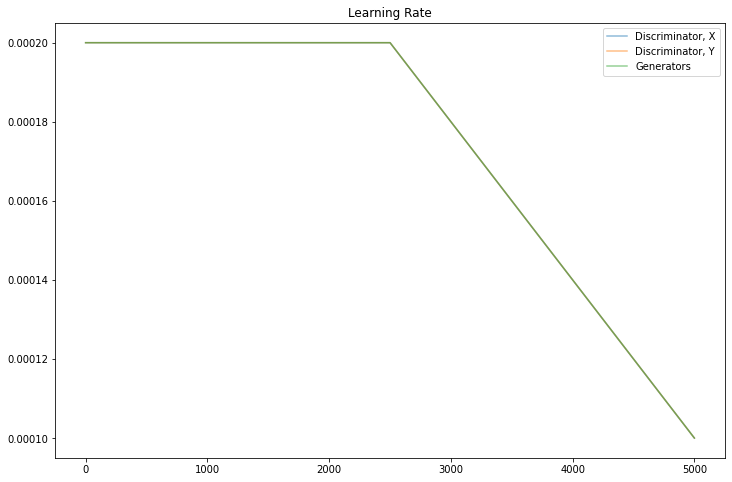

In [173]:
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(lrs_g_optimizer))
plt.plot(x , lrs_g_optimizer, label='Discriminator, X', alpha=0.5)
plt.plot(x , lrs_x_optimizer, label='Discriminator, Y', alpha=0.5)
plt.plot(x , lrs_y_optimizer, label='Generators', alpha=0.5)
plt.title("Learning Rate")
plt.legend()

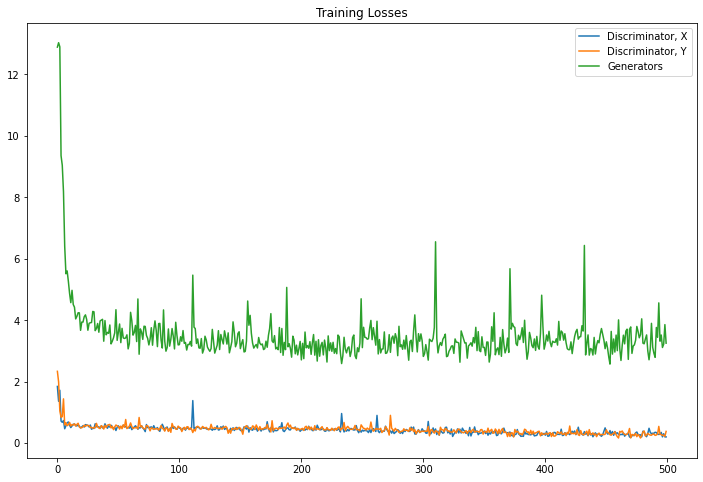

In [174]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X')
plt.plot(losses.T[1], label='Discriminator, Y')
plt.plot(losses.T[2], label='Generators')
plt.title("Training Losses")
plt.legend()

In [175]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

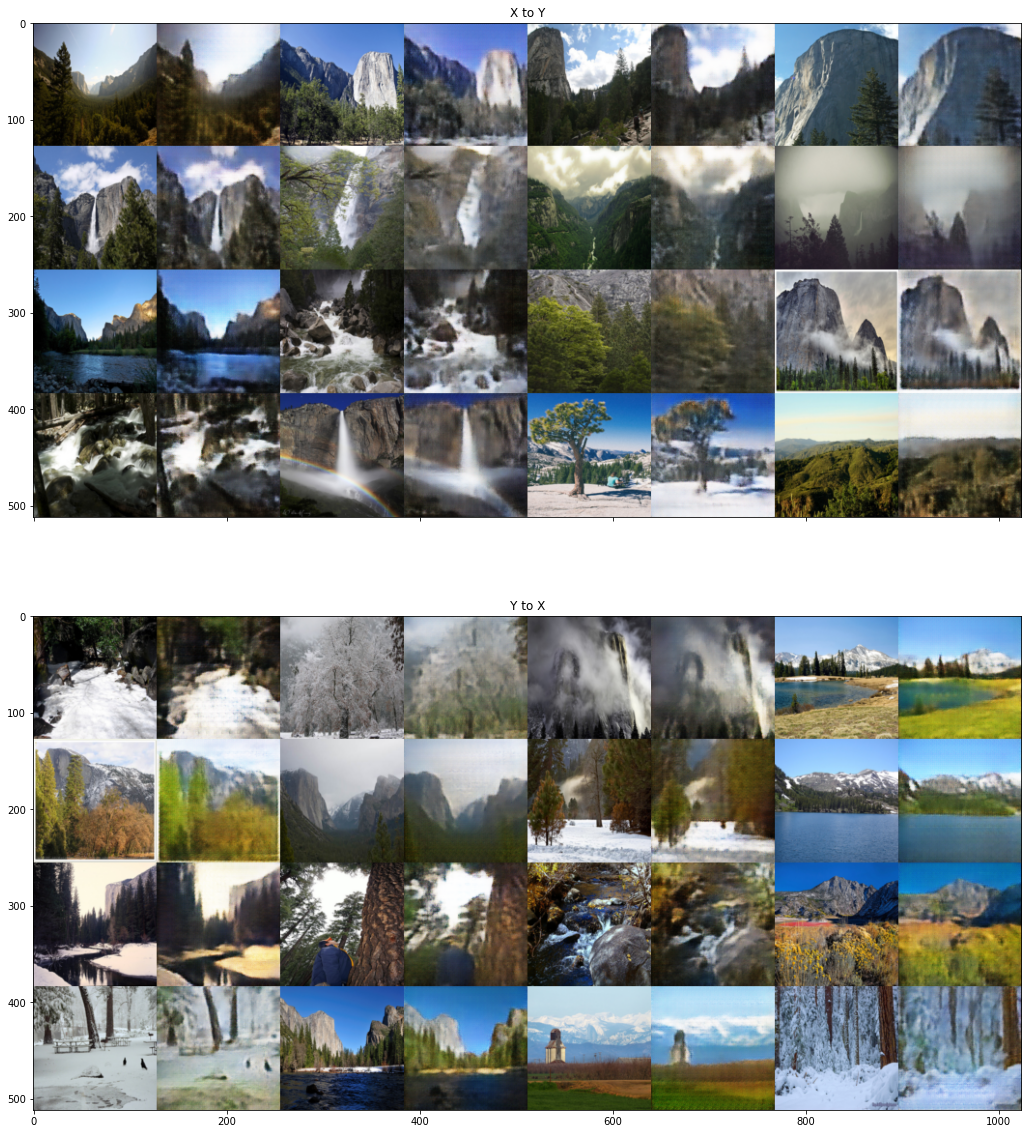

In [178]:
view_samples(5000, '/content/drive/MyDrive/GAN/samples_cyclegan')

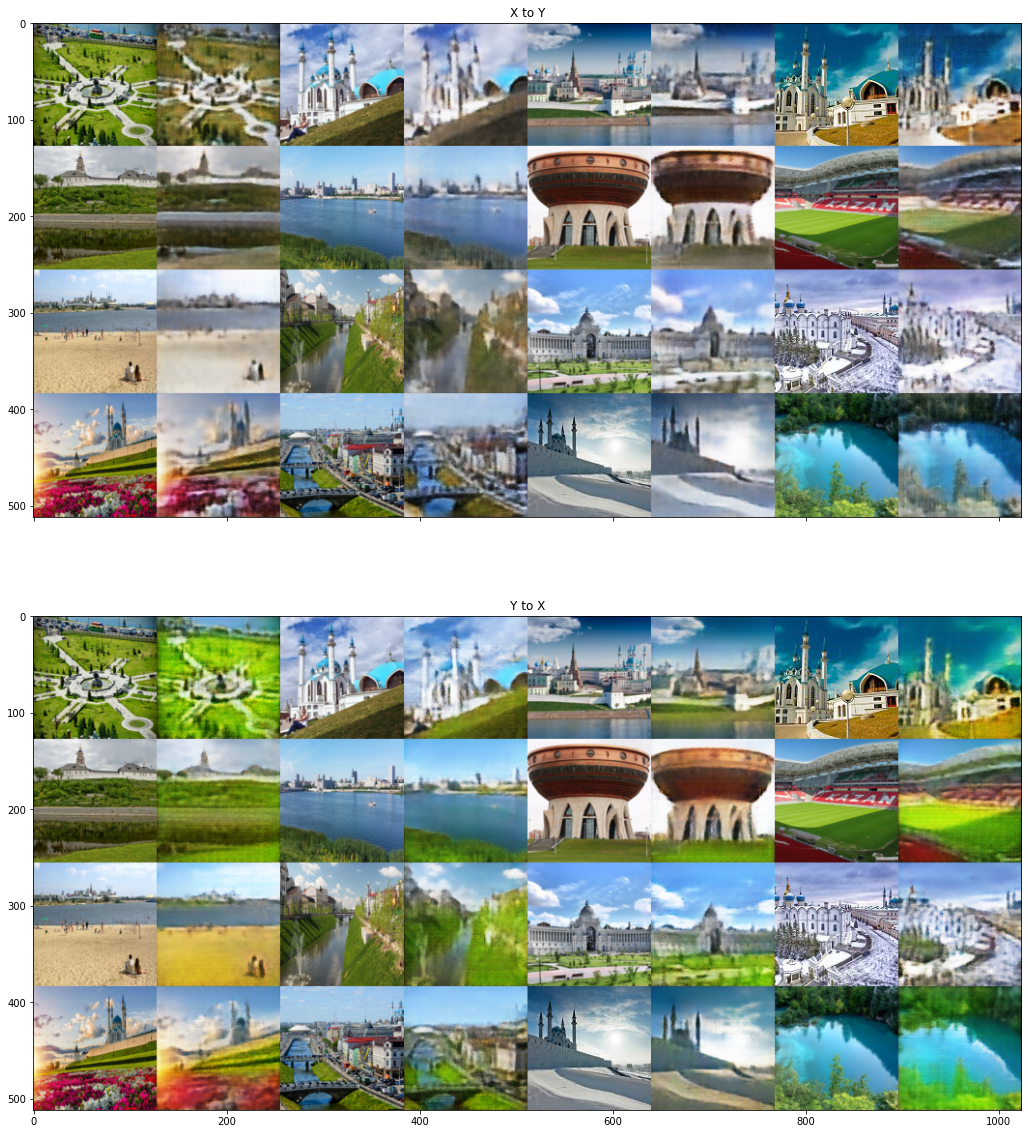

In [179]:
view_samples(5000, '/content/drive/MyDrive/Classroom/CycleGAN/my_samples_cyclegan')

##Используемые статьи и работы:
* [Overview of CycleGAN architecture and training](https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f)
* [Image-to-Image Translation using CycleGAN Model](https://towardsdatascience.com/image-to-image-translation-using-cyclegan-model-d58cfff04755)
* [CycleGAN Summer->Winter Image Translation PyTorch](https://www.kaggle.com/balraj98/cyclegan-summer-winter-image-translation-pytorch)
* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/#conv)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
* [Residual blocks — Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
* [Least Squares Generative Adversarial Networks](https://arxiv.org/pdf/1611.04076.pdf)
* [Guide to Pytorch Learning Rate Scheduling](https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling)